# 영화 내용 요약 정보를 이용한 장르 분류

## Data Preprocessing

In [418]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from konlpy.tag import Okt

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [351]:
movie_df = pd.read_csv( 'movie_reviews.csv' )

In [352]:
movie_df.head()

,Unnamed: 0,title,story,genre
0,0,그린 북,1962년 미국 입담과 주먹만 믿고 살아가던 토니 발레롱가비고 모텐슨는 교양과 우아...,드라마
1,1,가버나움,나를 세상에 태어나게 한 부모님을 고소하고 싶어요출생기록조차 없이 살아온 어쩌면 1...,드라마
2,2,베일리 어게인,귀여운 소년 이든의 단짝 반려견 베일리는 행복한 생을 마감한다하지만 눈을 떠보니 다...,모험
3,3,주전장,일본의 인종차별 문제를 다룬 영상을 올린 후 우익들의 공격 대상이 된 일본계 미국인...,다큐멘터리
4,4,포드 V 페라리,1960년대 매출 감소에 빠진 포드는 판매 활로를 찾기 위해스포츠카 레이스를 장악한...,액션


In [353]:
movie_df.shape

(384, 4)

### 장르 코드 변수 추가

In [354]:
genres_list = movie_df[ 'genre' ].unique().tolist()
genres_list

['드라마',
 '모험',
 '다큐멘터리',
 '액션',
 'SF',
 '애니메이션',
 '범죄',
 '멜로/로맨스',
 '전쟁',
 '가족',
 '판타지',
 '코미디',
 '공연실황',
 '한국',
 '서부',
 '뮤지컬',
 '공포',
 '미스터리']

In [355]:
genre_code_dict = dict( ( c, i ) for i, c in enumerate( genres_list ) )

In [356]:
genre_code_dict

{'드라마': 0,
 '모험': 1,
 '다큐멘터리': 2,
 '액션': 3,
 'SF': 4,
 '애니메이션': 5,
 '범죄': 6,
 '멜로/로맨스': 7,
 '전쟁': 8,
 '가족': 9,
 '판타지': 10,
 '코미디': 11,
 '공연실황': 12,
 '한국': 13,
 '서부': 14,
 '뮤지컬': 15,
 '공포': 16,
 '미스터리': 17}

In [357]:
max_genre_code_length = len( genre_code_dict )
max_genre_code_length

18

In [358]:
movie_df[ 'genre_code' ] = movie_df[ 'genre' ].map( lambda x : genre_code_dict[ x ] )

In [359]:
movie_df.head()

,Unnamed: 0,title,story,genre,genre_code
0,0,그린 북,1962년 미국 입담과 주먹만 믿고 살아가던 토니 발레롱가비고 모텐슨는 교양과 우아...,드라마,0
1,1,가버나움,나를 세상에 태어나게 한 부모님을 고소하고 싶어요출생기록조차 없이 살아온 어쩌면 1...,드라마,0
2,2,베일리 어게인,귀여운 소년 이든의 단짝 반려견 베일리는 행복한 생을 마감한다하지만 눈을 떠보니 다...,모험,1
3,3,주전장,일본의 인종차별 문제를 다룬 영상을 올린 후 우익들의 공격 대상이 된 일본계 미국인...,다큐멘터리,2
4,4,포드 V 페라리,1960년대 매출 감소에 빠진 포드는 판매 활로를 찾기 위해스포츠카 레이스를 장악한...,액션,3


In [360]:
movie_df.drop( movie_df.columns[ [ 0 ] ], axis = 'columns' )

,title,story,genre,genre_code
0,그린 북,1962년 미국 입담과 주먹만 믿고 살아가던 토니 발레롱가비고 모텐슨는 교양과 우아...,드라마,0
1,가버나움,나를 세상에 태어나게 한 부모님을 고소하고 싶어요출생기록조차 없이 살아온 어쩌면 1...,드라마,0
2,베일리 어게인,귀여운 소년 이든의 단짝 반려견 베일리는 행복한 생을 마감한다하지만 눈을 떠보니 다...,모험,1
3,주전장,일본의 인종차별 문제를 다룬 영상을 올린 후 우익들의 공격 대상이 된 일본계 미국인...,다큐멘터리,2
4,포드 V 페라리,1960년대 매출 감소에 빠진 포드는 판매 활로를 찾기 위해스포츠카 레이스를 장악한...,액션,3
...,...,...,...,...
379,바그다드 카페 : 디렉터스컷,황량한 사막 한가운데 자리 잡은 초라한 바그다드 카페 커피머신은 고장난지 오래고 먼...,코미디,11
380,론 서바이버,2005년 6월 28일 아프가니스탄에서 복무중인 네이비씰 대원 마커스 마이클 대니 ...,액션,3
381,국제시장,1950년대 한국전쟁 이후로부터 현재에 이르기까지 격변의 시대를 관통하며 살아온 우...,드라마,0
382,말레나,2차 대전이 한창인 햇빛 찬란한 지중해의 작은 마을 매혹적인 말레나 걸어갈 때면 어...,드라마,0


In [361]:
movie_df.shape

(384, 5)

In [362]:
movie_df[ :300 ]

,Unnamed: 0,title,story,genre,genre_code
0,0,그린 북,1962년 미국 입담과 주먹만 믿고 살아가던 토니 발레롱가비고 모텐슨는 교양과 우아...,드라마,0
1,1,가버나움,나를 세상에 태어나게 한 부모님을 고소하고 싶어요출생기록조차 없이 살아온 어쩌면 1...,드라마,0
2,2,베일리 어게인,귀여운 소년 이든의 단짝 반려견 베일리는 행복한 생을 마감한다하지만 눈을 떠보니 다...,모험,1
3,3,주전장,일본의 인종차별 문제를 다룬 영상을 올린 후 우익들의 공격 대상이 된 일본계 미국인...,다큐멘터리,2
4,4,포드 V 페라리,1960년대 매출 감소에 빠진 포드는 판매 활로를 찾기 위해스포츠카 레이스를 장악한...,액션,3
...,...,...,...,...,...
295,295,짱구는 못말려 극장판: 정면승부! 로봇아빠의 역습,어느 날 로봇이 되어 돌아온 짱구 아빠 짱구는 그 동안 영화에서만 봤던 슈퍼히어로가...,애니메이션,5
296,296,웨딩 드레스,미안해 우리 아가 엄마가 먼저 가서 너무 미안해 세상에서 젤 예쁜 내 보물 소라 엄...,드라마,0
297,297,드래곤볼 슈퍼: 브로리,힘의 대회 후 평화를 되찾은 지구그리고 더욱 강해지기 위해 수행에 몰두하고 있는 오...,애니메이션,5
298,298,정무문,정무문의 창시자이자 태극권의 사부인 허영가의 사망 소식을 들은 첸이소룡은 사부의 주...,액션,3


In [363]:
movie_df[ 300: ]

,Unnamed: 0,title,story,genre,genre_code
300,300,클리프행어,록키 산악 공원 구조 대원으로 일하던 게이브는 조난 당한 동료 핼의 연인 새라를 구...,액션,3
301,301,봄날은 간다,사운드 엔지니어 상우유지태 분는 치매에 걸린 할머니백성희 분와젊은 시절 상처한 한 ...,드라마,0
302,302,말모이,1940년대 우리말이 점점 사라져가고 있는 경성 극장에서 해고된 후 아들 학비 때문...,드라마,0
303,303,인터스텔라,세계 각국의 정부와 경제가 완전히 붕괴된 미래가 다가온다 지난 20세기에 범한 잘...,SF,4
304,304,블랙 호크 다운,{죽은 자만이 전쟁의 끝을 본다Only The Dead Have Seen The E...,전쟁,8
...,...,...,...,...,...
379,379,바그다드 카페 : 디렉터스컷,황량한 사막 한가운데 자리 잡은 초라한 바그다드 카페 커피머신은 고장난지 오래고 먼...,코미디,11
380,380,론 서바이버,2005년 6월 28일 아프가니스탄에서 복무중인 네이비씰 대원 마커스 마이클 대니 ...,액션,3
381,381,국제시장,1950년대 한국전쟁 이후로부터 현재에 이르기까지 격변의 시대를 관통하며 살아온 우...,드라마,0
382,382,말레나,2차 대전이 한창인 햇빛 찬란한 지중해의 작은 마을 매혹적인 말레나 걸어갈 때면 어...,드라마,0


### 학습에 사용할 변수에 대한 리스트 생성

In [364]:
movie_title = np.array( movie_df[ 'title' ].values ) # 영화 제목
movie_storys = np.array( movie_df[ 'story' ].values ) # 영화 줄거리
movie_genres = np.array( movie_df[ 'genre' ].values ) # 영화 장르
movie_genre_codes = np.array( movie_df[ 'genre_code' ].values ) # 영화 장르 코드

In [365]:
max_sample_length = len( movie_storys )
print( '전체 샘플의 개수 : {}'.format( max_sample_length ) )

전체 샘플의 개수 : 384


In [366]:
max_genre_length = len( genre_code_dict )
print( '총 장르의 개수 : {}'.format( max_genre_length ) )

총 장르의 개수 : 18


In [367]:
print( '첫번째 샘플 영화의 장르 : {}'.format( movie_genres[ 0 ] ) )

첫번째 샘플 영화의 장르 : 드라마


In [368]:
print('첫번째 샘플 영화의 장르 코드 : {}'.format( genre_code_dict[ movie_genres[ 0 ] ] ) )

첫번째 샘플 영화의 장르 코드 : 0


In [369]:
movie_storys.ndim, movie_storys.shape

(1, (384,))

In [370]:
movie_genres.ndim, movie_genres.shape

(1, (384,))

In [371]:
movie_genre_codes.ndim, movie_genre_codes.shape

(1, (384,))

In [372]:
movie_storys[ :3 ]

array(['1962년 미국 입담과 주먹만 믿고 살아가던 토니 발레롱가비고 모텐슨는 교양과 우아함 그 자체인천재 피아니스트 돈 셜리마허샬라 알리 박사의 운전기사 면접을 보게 된다백악관에도 초청되는 등 미국 전역에서 콘서트 요청을 받으며 명성을 떨치고 있는 돈 셜리는위험하기로 소문난 미국 남부 투어 공연을 떠나기로 결심하고투어 기간 동안 자신의 보디가드 겸 운전기사로 토니를 고용한다거친 인생을 살아온 토니 발레롱가와 교양과 기품을 지키며 살아온 돈 셜리 박사생각 행동 말투 취향까지 달라도 너무 다른 두 사람은그들을 위한 여행안내서 그린북에 의존해 특별한 남부 투어를 시작하는데',
       '나를 세상에 태어나게 한 부모님을 고소하고 싶어요출생기록조차 없이 살아온 어쩌면 12살 소년 자인으로부터',
       '귀여운 소년 이든의 단짝 반려견 베일리는 행복한 생을 마감한다하지만 눈을 떠보니 다시 시작된 견생 2회차 아니 3회차1등 경찰견 엘리에서 찰떡같이 마음을 알아주는 소울메이트 티노까지다시 태어날 때마다 성별과 생김새 직업에 이름도 바뀌지만여전히 영혼만은 사랑 충만 애교 충만 주인바라기 베일리어느덧 견생 4회차 방랑견이 되어 떠돌던 베일리는마침내 자신이 돌아온 진짜 이유를 깨닫고 어딘가로 달려가기 시작하는데'],
      dtype=object)

In [373]:
movie_genres[ :3 ]

array(['드라마', '드라마', '모험'], dtype=object)

In [374]:
movie_genre_codes[ :3 ]

array([0, 0, 1], dtype=int64)

### 형태소 분석 / 불용어 처리

In [375]:
okt = Okt()

In [376]:
stop_words = []

with open( 'stopwords.txt', 'r', encoding = 'utf-8' ) as f:
    lines = f.readlines()
    for line in lines:
        stop_words.append( line.rstrip( '\n' ) )

print( stop_words[ : 100 ] )

['아', '휴', '아이구', '아이쿠', '아이고', '어', '나', '우리', '저희', '따라', '의해', '을', '를', '에', '의', '가', '으로', '로', '에게', '뿐이다', '의거하여', '근거하여', '입각하여', '기준으로', '예하면', '예를 들면', '예를 들자면', '저', '소인', '소생', '저희', '지말고', '하지마', '하지마라', '다른', '물론', '또한', '그리고', '비길수 없다', '해서는 안된다', '뿐만 아니라', '만이 아니다', '만은 아니다', '막론하고', '관계없이', '그치지 않다', '그러나', '그런데', '하지만', '든간에', '논하지 않다', '따지지 않다', '설사', '비록', '더라도', '아니면', '만 못하다', '하는 편이 낫다', '불문하고', '향하여', '향해서', '향하다', '쪽으로', '틈타', '이용하여', '타다', '오르다', '제외하고', '이 외에', '이 밖에', '하여야', '비로소', '한다면 몰라도', '외에도', '이곳', '여기', '부터', '기점으로', '따라서', '할 생각이다', '하려고하다', '이리하여', '그리하여', '그렇게 함으로써', '하지만', '일때', '할때', '앞에서', '중에서', '보는데서', '으로써', '로써', '까지', '해야한다', '일것이다', '반드시', '할줄알다', '할수있다', '할수있어', '임에 틀림없다']


In [377]:
vocab = {}
movie_token_storys = []

for story in movie_storys:
    sentence = okt.nouns( story )
    result = []

    for word in sentence: 
        if word not in stop_words: 
            result.append( word )
            if word not in vocab:
                vocab[ word ] = 0 
            vocab[ word ] += 1
    movie_token_storys.append( result ) 
print( movie_token_storys )

[['미국', '입담', '주먹', '토니', '발레', '롱', '비고', '모텐슨는', '교양', '자체', '천재', '피아니스트', '돈', '셜리마허샬', '알리', '박사', '운전기사', '면접', '백악관', '초청', '미국', '전역', '콘서트', '요청', '명성', '돈', '셜리', '미국', '남부', '투어', '공연', '결심', '투어', '기간', '보디가드', '겸', '운전기사', '토니', '고용', '인생', '토니', '발레', '롱', '교양', '기품', '돈', '셜리', '박사', '생각', '행동', '말투', '취향', '달라', '두', '사람', '위', '여행안내서', '그린북', '의존', '남부', '투어', '시작'], ['세상', '부모님', '출생', '기록', '어쩌면', '살', '소년', '자인'], ['소년', '단짝', '반려견', '베', '일리', '생', '마감', '눈', '다시', '시작', '견생', '경찰견', '엘리', '찰떡', '마음', '소울메이트', '티노', '다시', '성별', '생김새', '직업', '이름', '영혼', '사랑', '충만', '애교', '충만', '주인', '베', '일리', '견생', '방랑견', '베', '일리', '마침내', '진짜', '이유', '어딘가', '시작'], ['일본', '인종차별', '문제', '영상', '후', '우익', '공격', '대상', '일본', '미국인', '유튜버', '미키', '데', '자키', '일본군', '위안부', '관', '기사', '기자', '우익', '인신공격', '문제', '호기심', '안고', '이야기', '전하', '주장', '반격', '인물', '비밀', '발견', '숨', '틈', '전쟁', '시작'], ['매출', '감소', '포드', '판매', '활', '찾기', '위해', '스포츠카', '레이스', '장악', '절대', '위', '페라리', '인수', '합병', '추진', '막대', 

### 영화 줄거리 정수 인코딩 / 영화 장르 원-홧 인코딩

In [378]:
max_words = 1000
num_classes = len( genre_code_dict )

tokenizer = Tokenizer( num_words = max_words + 2, oov_token = 'OOV' ) # 상위 1000개 단어만 사용
tokenizer.fit_on_texts( movie_token_storys )

In [379]:
movie_token_int_storys = tokenizer.texts_to_sequences( movie_token_storys )
print( movie_token_int_storys )

[[72, 1, 864, 311, 346, 1, 1, 1, 1, 865, 158, 866, 55, 1, 1, 151, 1, 1, 1, 1, 72, 1, 737, 446, 1, 55, 1, 72, 1, 347, 205, 122, 347, 867, 868, 1, 1, 311, 738, 74, 311, 346, 1, 1, 1, 55, 1, 151, 63, 389, 1, 1, 390, 21, 8, 29, 1, 1, 1, 1, 347, 4], [11, 560, 1, 447, 1, 25, 64, 1], [64, 1, 1, 348, 448, 259, 1, 34, 12, 4, 1, 1, 1, 1, 24, 1, 1, 12, 1, 1, 634, 77, 288, 6, 1, 1, 1, 217, 348, 448, 1, 1, 348, 448, 60, 126, 159, 1, 4], [186, 1, 449, 739, 19, 1, 152, 391, 186, 1, 1, 1, 206, 1, 1, 1, 392, 740, 1, 1, 1, 449, 393, 1, 78, 635, 1, 1, 507, 67, 23, 450, 741, 51, 4], [1, 1, 636, 1, 1, 195, 3, 1, 1, 869, 451, 29, 1, 1, 1, 1, 1, 1, 187, 1, 1, 1, 1, 870, 349, 636, 1, 1, 1, 1, 1, 131, 508, 1, 21, 40, 1, 20, 871, 1, 1, 1, 1, 1, 1, 742, 452, 636, 637, 1, 1, 1, 1, 3, 1, 1, 1, 394, 871, 1, 1, 1, 1, 1, 738, 1, 743, 312, 46, 1, 1, 1, 91, 1, 1, 1, 638, 636, 1, 1, 1, 1, 1, 1, 1, 872, 1, 8, 1, 1, 1, 29, 1, 4, 1, 1], [350, 51, 1, 1, 1, 639, 16, 453, 25, 42, 23, 51, 351, 260, 16, 14, 42, 1, 42, 1, 1, 561

In [380]:
max_X_length = max( len( l ) for l in movie_token_int_storys )
max_X_length

593

In [381]:
movie_token_pad_storys = pad_sequences( movie_token_int_storys, maxlen = max_X_length, padding = 'post' )
movie_token_pad_storys

array([[ 72,   1, 864, ...,   0,   0,   0],
       [ 11, 560,   1, ...,   0,   0,   0],
       [ 64,   1,   1, ...,   0,   0,   0],
       ...,
       [350,  51, 180, ...,   0,   0,   0],
       [131,   1, 930, ...,   0,   0,   0],
       [  1, 316, 957, ...,   0,   0,   0]])

In [382]:
movie_token_pad_storys.shape

(384, 593)

In [383]:
title_X = movie_title[ :300 ]
title_pred_X = movie_title[ 300: ]
genre_code_X = movie_genre_codes[ :300 ]
genre_code_pred_X = movie_genre_codes[ 300: ]

In [384]:
X = movie_token_pad_storys[ :300 ] # 학습용 feature X
pred_X = movie_token_pad_storys[ 300: ] # 학습 후 테스트 feature X

In [385]:
X

array([[ 72,   1, 864, ...,   0,   0,   0],
       [ 11, 560,   1, ...,   0,   0,   0],
       [ 64,   1,   1, ...,   0,   0,   0],
       ...,
       [ 83, 637,  19, ...,   0,   0,   0],
       [  1,   1,  96, ...,   0,   0,   0],
       [111, 544, 190, ...,   0,   0,   0]])

In [386]:
X.shape

(300, 593)

In [387]:
pred_X

array([[  1,   1,   1, ...,   0,   0,   0],
       [  1,   1, 532, ...,   0,   0,   0],
       [  1,  84,   1, ...,   0,   0,   0],
       ...,
       [350,  51, 180, ...,   0,   0,   0],
       [131,   1, 930, ...,   0,   0,   0],
       [  1, 316, 957, ...,   0,   0,   0]])

In [388]:
pred_X.shape

(84, 593)

In [389]:
movie_genre_codes

array([ 0,  0,  1,  2,  3,  0,  0,  0,  0,  4,  0,  0,  1,  5,  6,  4,  4,
        0,  7,  8,  0,  0,  9,  3,  0,  5,  5,  3,  7,  1,  3,  0,  0,  6,
        0, 10,  7,  0,  0,  0,  0, 11,  5,  0,  0,  3,  0, 11,  2,  0,  2,
        0,  5,  7,  0, 10,  4,  3,  0,  0, 11,  3, 11,  0,  5,  1,  5,  5,
        0, 12,  5,  6,  2, 11,  0,  0,  1,  0, 13,  5,  5, 11,  0,  5,  0,
        5,  4,  5,  0,  5,  7, 11,  5,  4,  0,  0,  4,  9,  0,  0,  5,  3,
        3,  5,  0,  0,  5,  0,  2,  0,  2,  3,  5,  5, 10,  3, 12,  7,  5,
       11, 10,  5,  0,  0,  7,  9,  0,  0,  3,  0,  1,  2,  0,  0,  0,  5,
       12,  3,  0,  2,  0, 14,  0,  2,  5,  4,  4,  3,  0,  3,  0,  0, 11,
        2,  5,  5, 15, 10,  2,  0, 10,  0,  5,  0,  0,  0,  3,  4,  4,  5,
        7,  5,  5,  3,  5, 11,  3,  0,  9,  0,  5,  0,  5,  0, 15,  3,  0,
        6,  5,  2,  5, 11,  0,  3,  5,  0,  4, 14,  0,  5,  0,  9,  5,  5,
        5,  3,  2,  5, 11,  2,  2,  0,  5,  4,  0, 11,  0,  3,  0,  7,  0,
       11,  4,  1,  0,  6

In [390]:
movie_genre_codes.shape

(384,)

In [391]:
genre_data = to_categorical( movie_genre_codes )
genre_data

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [392]:
y = genre_data[ :300 ] # 학습용 label X
pred_y = genre_data[ 300: ] # # 학습 후 테스트 label X

In [393]:
y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [394]:
y.shape

(300, 18)

In [395]:
pred_y

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [396]:
pred_y.shape

(84, 18)

###  훈련 데이터와 테스트 데이터 분리

In [397]:
( X_train, X_test, y_train, y_test ) = train_test_split( X, y, train_size = 0.8, random_state = 2)

In [398]:
print( X_train.shape )
print( X_test.shape )
print( y_train.shape )
print( y_test.shape )

(240, 593)
(60, 593)
(240, 18)
(60, 18)


In [399]:
print( X_train[ :5 ] ) 

[[  1  31   1 ...   0   0   0]
 [  1 231 206 ...   0   0   0]
 [718   1   1 ...   0   0   0]
 [306   1  38 ...   0   0   0]
 [518 145   1 ...   0   0   0]]


In [400]:
X_train.shape

(240, 593)

In [401]:
print( y_train[ :5 ] )
print( y_test[ :5 ] )

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [402]:
y_train.shape

(240, 18)

## 소프트맥스 회귀

### 훈련

In [403]:
model=Sequential()

model.add( Dense( max_genre_length, input_dim = max_X_length, activation = 'softmax' ) )
sgd = optimizers.SGD( lr = 0.01 )

model.compile( loss = 'categorical_crossentropy', optimizer = 'adam', metrics = [ 'accuracy' ] )
history = model.fit( X_train, y_train, batch_size = 1, epochs = 200, validation_data = ( X_test, y_test ) )

Train on 240 samples, validate on 60 samples
Epoch 1/200
240/240 [==============================] - 2s 9ms/sample - loss: 203.6795 - accuracy: 0.1375 - val_loss: 137.9309 - val_accuracy: 0.1500
Epoch 2/200
240/240 [==============================] - 1s 3ms/sample - loss: 117.7419 - accuracy: 0.2292 - val_loss: 126.7477 - val_accuracy: 0.1500
Epoch 3/200
240/240 [==============================] - 1s 2ms/sample - loss: 75.3574 - accuracy: 0.3125 - val_loss: 118.8347 - val_accuracy: 0.1833
Epoch 4/200
240/240 [==============================] - 1s 2ms/sample - loss: 41.2336 - accuracy: 0.4792 - val_loss: 119.2126 - val_accuracy: 0.2000
Epoch 5/200
240/240 [==============================] - 1s 3ms/sample - loss: 29.1602 - accuracy: 0.4917 - val_loss: 122.7704 - val_accuracy: 0.1667
Epoch 6/200
240/240 [==============================] - 1s 2ms/sample - loss: 18.9813 - accuracy: 0.6083 - val_loss: 118.6971 - val_accuracy: 0.2167
Epoch 7/200
240/240 [==============================] - 1s 3ms/sam

240/240 [==============================] - 1s 2ms/sample - loss: 3.7271 - accuracy: 0.8833 - val_loss: 213.6814 - val_accuracy: 0.2000
Epoch 57/200
240/240 [==============================] - 1s 2ms/sample - loss: 1.1122 - accuracy: 0.9250 - val_loss: 210.3063 - val_accuracy: 0.1833
Epoch 58/200
240/240 [==============================] - 1s 2ms/sample - loss: 1.1282 - accuracy: 0.9083 - val_loss: 215.4760 - val_accuracy: 0.2000
Epoch 59/200
240/240 [==============================] - 1s 2ms/sample - loss: 1.9442 - accuracy: 0.9042 - val_loss: 213.1933 - val_accuracy: 0.2167
Epoch 60/200
240/240 [==============================] - 1s 3ms/sample - loss: 1.6961 - accuracy: 0.9250 - val_loss: 216.7593 - val_accuracy: 0.1833
Epoch 61/200
240/240 [==============================] - 1s 3ms/sample - loss: 1.1561 - accuracy: 0.9333 - val_loss: 216.2153 - val_accuracy: 0.2000
Epoch 62/200
240/240 [==============================] - 1s 3ms/sample - loss: 1.7092 - accuracy: 0.9167 - val_loss: 210.2486 

240/240 [==============================] - 1s 2ms/sample - loss: 1.2371 - accuracy: 0.9542 - val_loss: 260.5113 - val_accuracy: 0.1833
Epoch 112/200
240/240 [==============================] - 1s 3ms/sample - loss: 0.3655 - accuracy: 0.9667 - val_loss: 258.2792 - val_accuracy: 0.1833
Epoch 113/200
240/240 [==============================] - 1s 3ms/sample - loss: 0.3422 - accuracy: 0.9708 - val_loss: 257.3096 - val_accuracy: 0.2000
Epoch 114/200
240/240 [==============================] - 1s 3ms/sample - loss: 0.3987 - accuracy: 0.9667 - val_loss: 257.2100 - val_accuracy: 0.1833
Epoch 115/200
240/240 [==============================] - 1s 3ms/sample - loss: 1.2096 - accuracy: 0.9667 - val_loss: 254.9519 - val_accuracy: 0.2167
Epoch 116/200
240/240 [==============================] - 1s 3ms/sample - loss: 1.5031 - accuracy: 0.9333 - val_loss: 259.9106 - val_accuracy: 0.1833
Epoch 117/200
240/240 [==============================] - 1s 3ms/sample - loss: 0.6591 - accuracy: 0.9542 - val_loss: 260

240/240 [==============================] - 1s 2ms/sample - loss: 0.9002 - accuracy: 0.9542 - val_loss: 317.0645 - val_accuracy: 0.1833
Epoch 167/200
240/240 [==============================] - 1s 2ms/sample - loss: 0.8044 - accuracy: 0.9375 - val_loss: 318.3932 - val_accuracy: 0.1833
Epoch 168/200
240/240 [==============================] - 1s 2ms/sample - loss: 0.6502 - accuracy: 0.9500 - val_loss: 317.3352 - val_accuracy: 0.1667
Epoch 169/200
240/240 [==============================] - 1s 3ms/sample - loss: 0.5111 - accuracy: 0.9750 - val_loss: 317.0022 - val_accuracy: 0.1667
Epoch 170/200
240/240 [==============================] - 1s 3ms/sample - loss: 0.5963 - accuracy: 0.9750 - val_loss: 316.8144 - val_accuracy: 0.1667
Epoch 171/200
240/240 [==============================] - 1s 3ms/sample - loss: 0.1039 - accuracy: 0.9917 - val_loss: 319.8460 - val_accuracy: 0.1667
Epoch 172/200
240/240 [==============================] - 1s 3ms/sample - loss: 0.1253 - accuracy: 0.9875 - val_loss: 320

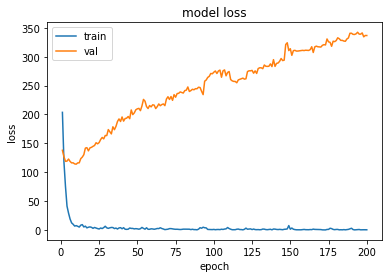

In [404]:
epochs = range( 1, len( history.history[ 'accuracy' ] ) + 1 )
plt.plot( epochs, history.history[ 'loss' ] )
plt.plot(epochs, history.history[ 'val_loss' ] )
plt.title( 'model loss' )
plt.ylabel( 'loss' )
plt.xlabel( 'epoch' )
plt.legend( [ 'train', 'val' ], loc = 'upper left' )
plt.show()

### 훈련 결과에 대한 예측

In [405]:
movie_df[ 300: ]

,Unnamed: 0,title,story,genre,genre_code
300,300,클리프행어,록키 산악 공원 구조 대원으로 일하던 게이브는 조난 당한 동료 핼의 연인 새라를 구...,액션,3
301,301,봄날은 간다,사운드 엔지니어 상우유지태 분는 치매에 걸린 할머니백성희 분와젊은 시절 상처한 한 ...,드라마,0
302,302,말모이,1940년대 우리말이 점점 사라져가고 있는 경성 극장에서 해고된 후 아들 학비 때문...,드라마,0
303,303,인터스텔라,세계 각국의 정부와 경제가 완전히 붕괴된 미래가 다가온다 지난 20세기에 범한 잘...,SF,4
304,304,블랙 호크 다운,{죽은 자만이 전쟁의 끝을 본다Only The Dead Have Seen The E...,전쟁,8
...,...,...,...,...,...
379,379,바그다드 카페 : 디렉터스컷,황량한 사막 한가운데 자리 잡은 초라한 바그다드 카페 커피머신은 고장난지 오래고 먼...,코미디,11
380,380,론 서바이버,2005년 6월 28일 아프가니스탄에서 복무중인 네이비씰 대원 마커스 마이클 대니 ...,액션,3
381,381,국제시장,1950년대 한국전쟁 이후로부터 현재에 이르기까지 격변의 시대를 관통하며 살아온 우...,드라마,0
382,382,말레나,2차 대전이 한창인 햇빛 찬란한 지중해의 작은 마을 매혹적인 말레나 걸어갈 때면 어...,드라마,0


In [406]:
pred_genre_code = model.predict_classes( pred_X, verbose = 0 )

In [407]:
def prediction( pred ):
    max_length = len( title_pred_X )
    true_count = 0
    false_count = 0
    
    print( '{0:^50}{1:^20}{2:^20}'.format( '영화제목','실제 장르', '예측 장르' ) )
    print( '{0:=^100}'.format( '=' ) )
    for i in range( max_length ):
        print( '{0:50}\t{1:20}\t{2:20}'.format( title_pred_X[ i ].strip(), 
                                            genres_list[ genre_code_pred_X[ i ] ], 
                                            genres_list[ pred[ i ] ] ) )
        if movie_genre_codes[ i ] == pred[ i ]:
            true_count += 1
        else:
            false_count += 1 

    print( '{0:=^100}'.format( '=' ) )
    print( 'true count : {0}\tfalse count : {1}'.format( true_count, false_count ) )        
    print( '{0:=^100}'.format( '=' ) )
    print( '재현율( Recall ) : {0}'.format( round( true_count / ( true_count + false_count ), 3 ) ) )        
    print( '{0:=^100}'.format( '=' ) )    
    print( '정확도( Accuracy ) : {}'.format( round( true_count / len( pred ) * 100, 3 ) ) )

In [408]:
prediction( pred_genre_code )

                       영화제목                              실제 장르               예측 장르        
클리프행어                                             	액션                  	드라마                 
봄날은 간다                                            	드라마                 	애니메이션               
말모이                                               	드라마                 	멜로/로맨스              
인터스텔라                                             	SF                  	애니메이션               
블랙 호크 다운                                          	전쟁                  	드라마                 
로건                                                	액션                  	멜로/로맨스              
스타워즈 에피소드 5 - 제국의 역습                              	SF                  	가족                  
아이덴티티                                             	드라마                 	멜로/로맨스              
하치 이야기                                            	가족                  	다큐멘터리               
박하사탕                                              	드라마                 	

In [409]:
def prepare_data( train_data, test_data, mode ): 
    t = Tokenizer( num_words = max_words ) 
    t.fit_on_texts( train_data )
    X_train = t.texts_to_matrix( train_data, mode = mode ) # 샘플 수 × max_words 크기의 행렬 생성
    X_test = t.texts_to_matrix( test_data, mode = mode ) # 샘플 수 × max_words 크기의 행렬 생성
    return X_train, X_test, t.index_word

In [410]:
X_data = movie_token_storys[ :300 ]
X_data

[['미국',
  '입담',
  '주먹',
  '토니',
  '발레',
  '롱',
  '비고',
  '모텐슨는',
  '교양',
  '자체',
  '천재',
  '피아니스트',
  '돈',
  '셜리마허샬',
  '알리',
  '박사',
  '운전기사',
  '면접',
  '백악관',
  '초청',
  '미국',
  '전역',
  '콘서트',
  '요청',
  '명성',
  '돈',
  '셜리',
  '미국',
  '남부',
  '투어',
  '공연',
  '결심',
  '투어',
  '기간',
  '보디가드',
  '겸',
  '운전기사',
  '토니',
  '고용',
  '인생',
  '토니',
  '발레',
  '롱',
  '교양',
  '기품',
  '돈',
  '셜리',
  '박사',
  '생각',
  '행동',
  '말투',
  '취향',
  '달라',
  '두',
  '사람',
  '위',
  '여행안내서',
  '그린북',
  '의존',
  '남부',
  '투어',
  '시작'],
 ['세상', '부모님', '출생', '기록', '어쩌면', '살', '소년', '자인'],
 ['소년',
  '단짝',
  '반려견',
  '베',
  '일리',
  '생',
  '마감',
  '눈',
  '다시',
  '시작',
  '견생',
  '경찰견',
  '엘리',
  '찰떡',
  '마음',
  '소울메이트',
  '티노',
  '다시',
  '성별',
  '생김새',
  '직업',
  '이름',
  '영혼',
  '사랑',
  '충만',
  '애교',
  '충만',
  '주인',
  '베',
  '일리',
  '견생',
  '방랑견',
  '베',
  '일리',
  '마침내',
  '진짜',
  '이유',
  '어딘가',
  '시작'],
 ['일본',
  '인종차별',
  '문제',
  '영상',
  '후',
  '우익',
  '공격',
  '대상',
  '일본',
  '미국인',
  '유튜버',
  '미키',
  '데',
  '자키',
  '일본군',

In [411]:
n_of_train = int( len( X_data ) * 0.8 )
n_of_test = int( len( X_data ) - n_of_train )
print( '{0}\t{1}'.format( n_of_train, n_of_test ) )

240	60


In [412]:
X_train = X_data[  :n_of_train ]
X_test = X_data[ :n_of_test ]

In [414]:
X_train, X_test, index_to_word = prepare_data( X_train, X_test, 'binary' )

In [415]:
print( '훈련 샘플 본문의 크기 : {}'.format( X_train.shape ) )
print( '훈련 샘플 레이블의 크기 : {}'.format( y_train.shape ) )
print( '테스트 샘플 본문의 크기 : {}'.format( X_test.shape ) )
print( '테스트 샘플 레이블의 크기 : {}'.format( y_test.shape ) )

훈련 샘플 본문의 크기 : (240, 1000)
훈련 샘플 레이블의 크기 : (240, 18)
테스트 샘플 본문의 크기 : (60, 1000)
테스트 샘플 레이블의 크기 : (60, 18)


In [424]:
model = Sequential()

model.add( Dense(256, input_shape = ( max_words, ), activation='relu' ) )
model.add( Dropout( 0.5 ) )
model.add( Dense( 128, activation = 'relu' ) )
model.add( Dropout( 0.5 ) )
model.add( Dense( num_classes, activation = 'softmax' ) )

model.compile( loss = 'categorical_crossentropy', optimizer = 'adam', metrics = [ 'accuracy' ] )
model.fit( X_train, y_train, batch_size = 128, epochs = 200, verbose = 1, validation_split = 0.1 )

score = model.evaluate( X_test, y_test, batch_size = 128, verbose = 0 )

Train on 216 samples, validate on 24 samples
Epoch 1/200
216/216 [==============================] - 2s 8ms/sample - loss: 2.9693 - accuracy: 0.0556 - val_loss: 2.7842 - val_accuracy: 0.1250
Epoch 2/200
216/216 [==============================] - 0s 185us/sample - loss: 2.7842 - accuracy: 0.1157 - val_loss: 2.6802 - val_accuracy: 0.2917
Epoch 3/200
216/216 [==============================] - 0s 167us/sample - loss: 2.6513 - accuracy: 0.2269 - val_loss: 2.5868 - val_accuracy: 0.3333
Epoch 4/200
216/216 [==============================] - 0s 213us/sample - loss: 2.5036 - accuracy: 0.2870 - val_loss: 2.5041 - val_accuracy: 0.3333
Epoch 5/200
216/216 [==============================] - 0s 167us/sample - loss: 2.4483 - accuracy: 0.3102 - val_loss: 2.4393 - val_accuracy: 0.3333
Epoch 6/200
216/216 [==============================] - 0s 241us/sample - loss: 2.2701 - accuracy: 0.3472 - val_loss: 2.3974 - val_accuracy: 0.3333
Epoch 7/200
216/216 [==============================] - 0s 181us/sample - lo

Epoch 56/200
216/216 [==============================] - 0s 153us/sample - loss: 0.2257 - accuracy: 0.9444 - val_loss: 3.4579 - val_accuracy: 0.1667
Epoch 57/200
216/216 [==============================] - 0s 148us/sample - loss: 0.1806 - accuracy: 0.9815 - val_loss: 3.4906 - val_accuracy: 0.1667
Epoch 58/200
216/216 [==============================] - 0s 144us/sample - loss: 0.1957 - accuracy: 0.9537 - val_loss: 3.5219 - val_accuracy: 0.1667
Epoch 59/200
216/216 [==============================] - 0s 208us/sample - loss: 0.1987 - accuracy: 0.9676 - val_loss: 3.5475 - val_accuracy: 0.1667
Epoch 60/200
216/216 [==============================] - 0s 222us/sample - loss: 0.1819 - accuracy: 0.9722 - val_loss: 3.5719 - val_accuracy: 0.1667
Epoch 61/200
216/216 [==============================] - 0s 218us/sample - loss: 0.1522 - accuracy: 0.9815 - val_loss: 3.5963 - val_accuracy: 0.1667
Epoch 62/200
216/216 [==============================] - 0s 185us/sample - loss: 0.1973 - accuracy: 0.9537 - val_

216/216 [==============================] - 0s 171us/sample - loss: 0.0776 - accuracy: 0.9861 - val_loss: 4.5220 - val_accuracy: 0.1667
Epoch 112/200
216/216 [==============================] - 0s 222us/sample - loss: 0.0528 - accuracy: 0.9907 - val_loss: 4.5182 - val_accuracy: 0.1667
Epoch 113/200
216/216 [==============================] - 0s 181us/sample - loss: 0.0510 - accuracy: 0.9907 - val_loss: 4.5192 - val_accuracy: 0.1667
Epoch 114/200
216/216 [==============================] - 0s 213us/sample - loss: 0.0583 - accuracy: 0.9815 - val_loss: 4.5188 - val_accuracy: 0.1667
Epoch 115/200
216/216 [==============================] - 0s 190us/sample - loss: 0.0512 - accuracy: 0.9861 - val_loss: 4.5295 - val_accuracy: 0.1667
Epoch 116/200
216/216 [==============================] - 0s 153us/sample - loss: 0.0756 - accuracy: 0.9861 - val_loss: 4.5523 - val_accuracy: 0.1667
Epoch 117/200
216/216 [==============================] - 0s 222us/sample - loss: 0.0647 - accuracy: 0.9907 - val_loss: 4

216/216 [==============================] - 0s 176us/sample - loss: 0.0345 - accuracy: 0.9907 - val_loss: 5.1026 - val_accuracy: 0.1667
Epoch 166/200
216/216 [==============================] - 0s 204us/sample - loss: 0.0544 - accuracy: 0.9861 - val_loss: 5.0982 - val_accuracy: 0.1667
Epoch 167/200
216/216 [==============================] - 0s 194us/sample - loss: 0.0579 - accuracy: 0.9861 - val_loss: 5.0894 - val_accuracy: 0.1667
Epoch 168/200
216/216 [==============================] - 0s 194us/sample - loss: 0.0389 - accuracy: 0.9907 - val_loss: 5.0742 - val_accuracy: 0.1667
Epoch 169/200
216/216 [==============================] - 0s 241us/sample - loss: 0.0338 - accuracy: 0.9907 - val_loss: 5.0575 - val_accuracy: 0.1667
Epoch 170/200
216/216 [==============================] - 0s 241us/sample - loss: 0.0291 - accuracy: 0.9907 - val_loss: 5.0402 - val_accuracy: 0.1667
Epoch 171/200
216/216 [==============================] - 0s 208us/sample - loss: 0.0353 - accuracy: 0.9861 - val_loss: 5

In [427]:
t = Tokenizer( num_words = max_words ) 
t.fit_on_texts( train_data )
pred_X = t.texts_to_matrix( train_data, mode = mode ) # 샘플 수 × max_words 크기의 행렬 생성
pred_genre_code = model.predict_classes( pred_X, verbose = 0 )

ValueError: Error when checking input: expected dense_22_input to have shape (1000,) but got array with shape (593,)

In [426]:
prediction( pred_genre_code )

                       영화제목                              실제 장르               예측 장르        
클리프행어                                             	액션                  	드라마                 
봄날은 간다                                            	드라마                 	애니메이션               
말모이                                               	드라마                 	멜로/로맨스              
인터스텔라                                             	SF                  	애니메이션               
블랙 호크 다운                                          	전쟁                  	드라마                 
로건                                                	액션                  	멜로/로맨스              
스타워즈 에피소드 5 - 제국의 역습                              	SF                  	가족                  
아이덴티티                                             	드라마                 	멜로/로맨스              
하치 이야기                                            	가족                  	다큐멘터리               
박하사탕                                              	드라마                 	